### What I want for future iterations
- ~~RSI functionality~~
- ~~Ability to handle multiple stocks at a time~~
- ~~Shorter time spans (Looking to swing trade with about 2 week periods rather than over the course of years)~~
- Improvements to algorithm. 
- ~~Make so stocks can import from yahoo finance~~
- Some addition of possible sentiment analysis through web scraping would be very interesting.
- Alpaca API usage that actually trades in paper through Alpaca

# Initialize Portfolio
We will use this class to trade the stocks and track the algorithms effectiveness.

In [1]:
#Uses the dual moving average crossover to detirmine when to buy and sell stock


import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import shutil, os, time, glob
import requests
from get_all_tickers import get_tickers as gt
from statistics import mean
import seaborn as sns
plt.style.use('fivethirtyeight')

In [2]:
#Amount of money in our portfolio.
class InvestmentPortfolio:
    """Creates an investment portfolio that asks for an initial investment and a trade quantity. This will keep track of our trades."""
    def __init__(self, initial_investment, trade_quantity):
        self.initial_investment = initial_investment
        self.trade_quantity = trade_quantity
        self.tradeRecords = []
        self.final_investment = initial_investment
    
    def buyStock(self,position):
        position = position
        self.final_investment -= self.trade_quantity * TradeData['Prices'][position]
        self.tradeRecords.append("Bought: " + str(self.trade_quantity) + " stock(s) at: " + str(TradeData['Prices'][position]))
    
    def sellStock(self,position):
        self.final_investment += self.trade_quantity * TradeData['Prices'][position]
        self.tradeRecords.append("Sold: " + str(self.trade_quantity) + " stock(s) at: " + str(TradeData['Prices'][position]))




## Retrieve Data From Yahoo Finance And Saves It In Path 

In [3]:
#List of tickers we want to analyze, change this to get more stocks.
tickers = ['AAPL', 'AMZN']
print("The amount of stocks chosen to observe: " + str(len(tickers)))

The amount of stocks chosen to observe: 2


In [12]:
#Clears the old stock data
shutil.rmtree(r"C:\Users\Jack\Google Drive\The Drive\DataAnalytics\Stock Trading\HistoricalData")
os.mkdir(r"C:\Users\Jack\Google Drive\The Drive\DataAnalytics\Stock Trading\HistoricalData")

#Clears RSI Folder
shutil.rmtree(r"C:\Users\Jack\Google Drive\The Drive\DataAnalytics\Stock Trading\RSIData")
os.mkdir(r"C:\Users\Jack\Google Drive\The Drive\DataAnalytics\Stock Trading\RSIData")

#The period and interval of the data we want on our stocks.
prd= '1d'
intv='1m'


Stock_Failure = 0
Stocks_Not_Imported = 0
Amount_of_API_Calls = 0
v=0

while (v < len(tickers)) and (Amount_of_API_Calls < 1800):
    try:
        ticker_name = str(tickers[v])
        print("Iteration = " + str(v))
        stock = tickers[v]  # Gets the current stock ticker
        temp = yf.Ticker(str(stock))
        Hist_data = temp.history(period=prd, interval=intv)  # Tells yfinance what kind of data we want about this stock (In this example, all of the historical data)
        Hist_data.to_csv(r"C:\Users\Jack\Google Drive\The Drive\DataAnalytics\Stock Trading\HistoricalData/%s.csv" % ticker_name)  # Saves the historical data in csv format for further processing later
        time.sleep(2)  # Pauses the loop for two seconds so we don't cause issues with Yahoo Finance's backend operations
        Amount_of_API_Calls += 1 
        Stock_Failure = 0
        v += 1  # Iteration to the next ticker
    except ValueError:
        print("Yahoo Finance Backend Error, Attempting to Fix")  # An error occured on Yahoo Finance's backend. We will attempt to retreive the data again
        if Stock_Failure > 5:  # Move on to the next ticker if the current ticker fails more than 5 times
            v+=1
            Stocks_Not_Imported += 1
        Amount_of_API_Calls += 1
        Stock_Failure += 1
    # Handle SSL error
    except requests.exceptions.SSLError as e:
        print("Yahoo Finance Backend Error, Attempting to Fix SSL")  # An error occured on Yahoo Finance's backend. We will attempt to retreive the data again
        if Stock_Failure > 5:  # Move on to the next ticker if the current ticker fails more than 5 times
            v+=1
            Stocks_Not_Imported += 1
        Amount_of_API_Calls += 1
        Stock_Failure += 1
print("The amount of stocks we successfully imported: " + str(v - Stocks_Not_Imported))

Iteration = 0
Iteration = 1
The amount of stocks we successfully imported: 2


# Generation of RSI Data

In [13]:
#Creates a data frame we will used later for analysis of different stocks.
Compare_Stocks = pd.DataFrame(columns=["Company", "Days_Observed", "Crosses", 
                                       "True_Positive", "False_Positive", "True_Negative", 
                                       "False_Negative", "Sensitivity", 
                                       "Specificity", "Accuracy", "TPR", "FPR"]) 

i = 0
while (i < len(tickers)):
    ticker_name = str(tickers[i])
    Hist_data = pd.read_csv(r"C:\Users\Jack\Google Drive\The Drive\DataAnalytics\Stock Trading\HistoricalData/%s.csv" % ticker_name)
    Company = str(tickers)[i]
    
    #Holds prices of a stock
    prices = []
    #iterator for our nested while loop
    c=0
    #add closing prices to price list and ensure we start at greater than 2 dollars per share
    while c < len(Hist_data):
        if Hist_data.iloc[c,4]:
            prices.append(Hist_data.iloc[c,4])
        c+=1
        
    #Makes a dataframe out of our prices data
    prices_df = pd.DataFrame(prices)
    
    #Iterator for our next while loop
    d=0
    upPrices = []
    downPrices = []
    
    #While loop that records the amount that prices moved up or down in a certain position.
    while d < len(prices):
        #If we are on our first iteration, just record the prices as is
        if d == 0:
            upPrices.append(0)
            downPrices.append(0)
        else:  
            if (prices[d]-prices[d-1])>0:  #If price at location - price at previous location is greater than zero, we record an up price
                upPrices.append(prices[d]-prices[d-1])
                downPrices.append(0)
            else:
                downPrices.append(prices[d]-prices[d-1]) #Converse of previous note
                upPrices.append(0)
        d += 1
    
    #Iterator for our next while loop in this piece of the program.
    x = 0
    avg_gain = []
    avg_loss = []
    #  Loop to calculate the average gain and loss
    while x < len(upPrices):
        if x < 15:
            avg_gain.append(0)
            avg_loss.append(0)
        else:
            sumGain = 0
            sumLoss = 0
            y = x - 14
            while y <= x:
                sumGain += upPrices[y]
                sumLoss += downPrices[y]
                y += 1
            avg_gain.append(sumGain/14)
            avg_loss.append(abs(sumLoss/14))
        x += 1
    
    #Iterator for our final while loop that then calculates the RSI value and stores it.
    p = 0
    RS = []
    RSI = []
    #  Loop to calculate RSI and RS
    while p < len(prices):
        if p <15:
            RS.append(0)
            RSI.append(0)
        else:
            RSvalue = (avg_gain[p]/avg_loss[p])
            RS.append(RSvalue)
            RSI.append(100 - (100/(1+RSvalue)))
        p+=1
    #  Creates the csv for each stock's RSI and price movements
    df_dict = {
        'Prices' : prices,
        'upPrices' : upPrices,
        'downPrices' : downPrices,
        'AvgGain' : avg_gain,
        'AvgLoss' : avg_loss,
        'RS' : RS,
        'RSI' : RSI
    }
    df = pd.DataFrame(df_dict, columns = ['Prices', 'upPrices', 'downPrices', 'AvgGain','AvgLoss', 'RS', "RSI"])
    df.to_csv(r"C:\Users\Jack\Google Drive\The Drive\DataAnalytics\Stock Trading\RSIData/RSI_%s.csv" % ticker_name)
    
    i += 1



# Data Collection Complete

Now that we have all the data we need, we can start to detirmine the best strategy for using the RSI to predict
stock prices, and therefore use it to analyze real time markets and see if its worth buying a stock at a specific point of
time!

# Visualize Data

In [10]:
#Basic plot
vis_ticker = input('Enter Stock Ticker To Graph: ')
data = pd.read_csv(r"C:\Users\Jack\Google Drive\The Drive\DataAnalytics\Stock Trading\RSIData\RSI_%s.csv" % vis_ticker)


Enter Stock Ticker To Graph: AAPL


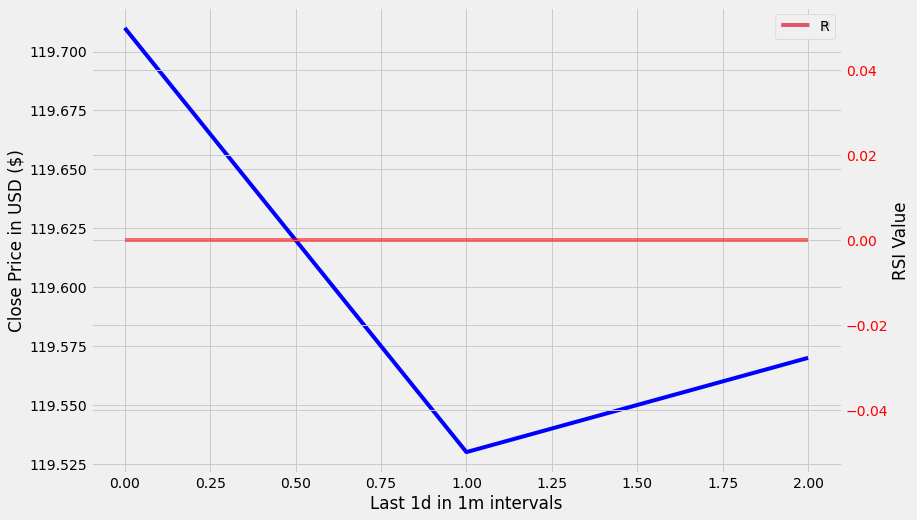

In [11]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.set_xlabel('Last '+prd+' in '+intv+' intervals')
ax1.set_ylabel('Close Price in USD ($)')
ax1.plot(data['Prices'], color='blue')
ax1.legend('Price')
ax1.tick_params(axis='y')

ax2 = ax1.twinx() 

ax2.set_ylabel('RSI Value')
ax2.plot(data['RSI'], color='red', alpha=.55)
ax2.legend('RSI')
ax2.tick_params(axis='y', labelcolor='red')

# RSI Visualization 

In [11]:
TradeData['RSI'].describe()

NameError: name 'TradeData' is not defined

NameError: name 'TradeData' is not defined

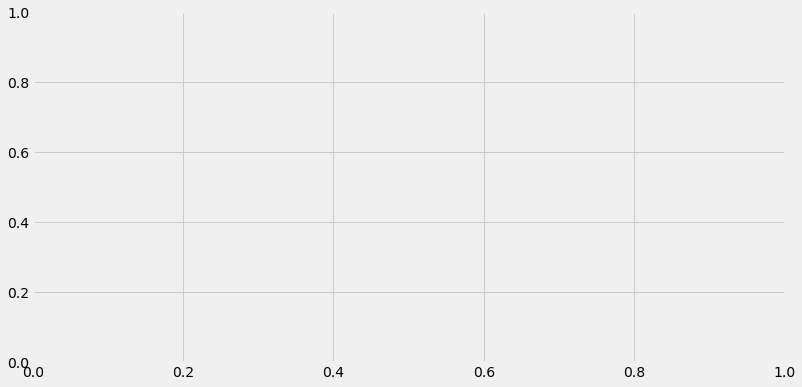

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(TradeData['RSI'])

In [13]:
sns.countplot(TradeData['RSI']<10)

NameError: name 'TradeData' is not defined

C:\Users\Jack\Documents\Python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='RSI', ylabel='count'>

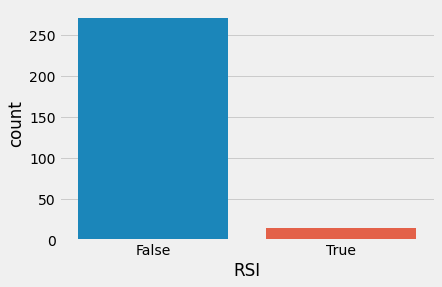

In [68]:
sns.countplot(TradeData['RSI']>90)

# Generate Buy And Sell Signals

This is the meat of the program. We are now going to employ a couple of different strategies to try and maximize our profit. We give ourselves some money, and based on the prices in TradeData and the RSI signals we have, we are going to run through this historical data and attempt to predict good buy and sell times. Then, we will unleash it on some other different stocks and try to maximize our profit. I will be including some risk appetite values that will affect the desire of the algorithm to take different plays.

# Important!!! Run a while loop that tests different buy and sell limit values and observe the results.

In [14]:
#This prepares tracking the RSI signals we get based on the RSI value.

bot_trade_ticker = input("Input ticker you want to analyze: ")
TradeData = pd.read_csv(r"C:\Users\Jack\Google Drive\The Drive\DataAnalytics\Stock Trading\RSIData\RSI_%s.csv" % bot_trade_ticker)

RSI_selections = []

#These0140 are our RSI limits. We can change these around for different results
buy_limit = 30
sell_limit = 75

#This is the wait "period" before we sell after buying at a low RSI. 
wait_period = 14

Input ticker you want to analyze: AAPL


# Run Algorithm

First we generate our buy and sell signals.

In [64]:

a = 0
while a < len(TradeData):
    if TradeData['RSI'][a] == 0:
        RSI_selections.append('No Signal')
    elif TradeData['RSI'][a] <=buy_limit:
        RSI_selections.append('Buy Signal')
    elif TradeData['RSI'][a] >= sell_limit:
        RSI_selections.append('Sell Signal')
    else:
        RSI_selections.append('No Signal')
    a+=1

Signals = pd.DataFrame(RSI_selections,columns=['Signal'])
TradeData = TradeData.join(Signals)

In [66]:
portfolio = InvestmentPortfolio(100000, 100)
OrderTracker = pd.DataFrame(columns=['BuyID', 'BQuantity','BPrice','BTotal','SellID','SQuantity','SPrice','STotal'])
a = 0
#If we buy, it will change to 1. This will only flip back to 0 once we have sold. 
#(Making one purchase at a time for simplicity sake for now)
buy_sell_boolean = 0

#Now we will run through the whole RSI TradeData dataframe.
#We will track our buy and sell orders, and get a final portfolio value at the end.
#This will also let us keep track of our portfolio value.
while a < len(TradeData):
    if(buy_sell_boolean == 0 and TradeData['Signal'][a] == 'Buy Signal'):
        portfolio.buyStock(a)
        buy_sell_boolean = 1
    elif(buy_sell_boolean == 1 and TradeData['Signal'][a] == 'Sell Signal'):
        portfolio.sellStock(a)
        buy_sell_boolean = 0
    else:
        pass
    a+=1

# Performance Check

In [67]:
print('Final Investment: '+str(portfolio.final_investment))
print('Profit: '+str(portfolio.final_investment - portfolio.initial_investment))
print('List of purchase and sell orders')
print(portfolio.tradeRecords)

Final Investment: 100168.0
Profit: 168.0
List of purchase and sell orders
['Bought: 100 stock(s) at: 113.87', 'Sold: 100 stock(s) at: 112.28', 'Bought: 100 stock(s) at: 113.3', 'Sold: 100 stock(s) at: 116.57']


# Further Improvements To Be Made
- Stop limits to minimize losses!
- Averaging into a play.
- Risk appetite (Sort of plays into stop limits: What kind of spread are we looking for risk wise?)
- Patience score
- At least attempt to apply a neural network.
